# Этап 2. Работа с данными, визуализации и лингвистика

В этой части обрабатываем данные и строим первые визуализации. Напомним, чт о по итогам парсинга собрали csv-файл с 5000 наблюдений по 10 признакам. Признаки: название фильма, год выпуска, 2 оценки и место в разных рейтингах, длительность, жанр, описание и количество голосов, отданных за этот фильм в сервисе.

**Что можно сделать с данными?**

Все качественные данные присутствуют, остуствуют оценки в некоторых наблюдениях. Оценки нельзя заменить медианой, средним или другим показателем без потери качества будущей модели, поэтому можем удалить их. Кроме того, в некоторых данных отсутсвует количество голосов за фильм и длительность продукта, но здесь оставим данные и используем для отдельного обучения.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
import scipy.stats as sts
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import train_test_split
from collections import defaultdict

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [9]:
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (8, 4)

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [10]:
df = pd.read_csv('/content/list.csv')
df.dropna(subset=['imdb_rate', 'metascore_rate'], inplace=True)
df.to_csv('result.csv', index = False )

df.head()

,name,url,global_rate,release_year,imdb_rate,metascore_rate,description,votes,duration,genre
0,Человек-паук: Паутина вселенных,/title/tt9362722/,1.,(2023),9,86.0,"Miles Morales catapults across the Multiverse,...",112055.0,140 min,"Animation, Action, Adventure"
1,Русалочка,/title/tt5971474/,2.,(I) (2023),"7,2",59.0,A young mermaid makes a deal with a sea witch ...,79594.0,135 min,"Adventure, Family, Fantasy"
2,Трансформеры: Восхождение Звероботов,/title/tt5090568/,3.,(2023),"6,6",42.0,"During the '90s, a new faction of Transformers...",16401.0,127 min,"Action, Adventure, Sci-Fi"
4,Человек-паук: Через Вселенные,/title/tt4633694/,5.,(2018),"8,4",87.0,Teen Miles Morales becomes the Spider-Man of h...,584309.0,117 min,"Animation, Action, Adventure"
5,Флэш,/title/tt0439572/,6.,(2023),"7,6",60.0,Barry Allen uses his super speed to change the...,NaN,144 min,"Action, Adventure, Fantasy"


Навели красоту в данных и оставили только полезные наблюдения.

**Дальше — исследуем данные и ищем интересные закономерности.**

In [11]:
df.describe()
#информация о данных файла

,metascore_rate,votes
count,4344.000000,4.343000e+03
mean,59.154926,1.709215e+05
std,17.564137,2.306729e+05
min,1.000000,9.000000e+00
25%,47.000000,4.274500e+04
50%,59.000000,9.655900e+04
75%,72.000000,2.033625e+05
max,100.000000,2.751362e+06


Для начала посмотрим, какие жанры встречаются наиболее часто.

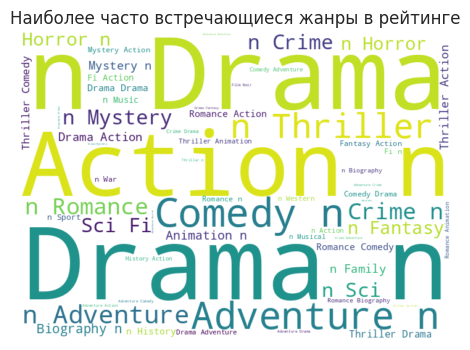

In [12]:
text_bag = df['genre'].tolist()
for i in range(0, len(text_bag)):
    text_bag[i] = str(text_bag[i]).replace(',', '/n')
text = ' '.join(text_bag)
wordcloud = WordCloud(width=700, height=500, background_color='white')
wordcloud.generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.title('Наиболее часто встречающиеся жанры в рейтинге');
plt.show()

**Результат:**

Action

Drama

Comedy

Adventure

# Игры со словами

Поработаем с тем, в каких жанрах и насоклько часто используются слова по определенным темам: война, убийства, приключения, любовь.

Для этого сначала соберем списки бесполезных и тематических слов.
Бесполезные используем, чтобы убрать лишнее, а искать будем по тематическим.

О том, как собирали списки, рассказали в отдельном файлике wordslists

In [14]:
#этот кусок сохраняет списка слов в файлики, чтобы потом их считывать удобно

unmeaning_word_list = ['a', '.', 'the', ',', 'to', 'of', 'and', 'in', 'his', 'is',
                      'with', 'an', "her's", 'on', 'for', 'their', 'by', 'who', 'he',
                      'from', 'that', 'as', 'into', 'they', 'are', 'when', 'after',
                      'she', 'at', 'must', 'him', 'up', 'man', 'has', 'woman', 'but',
                      'new', 'out', 'world', 'one', 'find', 'where', 'two',
                      'it', 'them', 'be', 'finds', 'girl', 'while', 'help', 'becomes',
                      'years', 'have', 'only', 'town', 'team', 'boy',
                      'lives', 'being', 'son', 'himself', 'all', 'back', 'save',
                      'down', 'about', 'between', 'which', 'own', 'will', 'can', 'get',
                      '-', 'takes', "'s", 'become', 'before', 'other', 'time', 'take', 'through',
                      'city', 'off', 'not', 'goes', 'over', 'three', 'begins',
                      ':', 'stop', 'was', 'tries', 'make', 'first', 'falls', 'more', 'go',
                      'themselves', 'gets', 'each', 'what', 'city', 'whose', 'been',
                      'meets', 'comes', 'across', 'escape', 'forced', 'forces', 'set', 'this',
                      'living', 'herself', 'or', 'try', "n't", 'named', 'human', 'husband',
                      'sets', 'trying', 'men', 'come', 'live', 'under', 'behind', 'left', 'away',
                      'both', 'than', 'around', 'women', 'serial', 'ii', '?', 'four', 'there',
                      'while', 'he', 'on', 'do', 'so', 'south', 'during', 'fall', 'look', 'taken',
                      'no', 'starts', 'different', 'wants', 'based', '--', 'works', 'they',
                      'even', 'san', 'if', 'then', 'next', 'also', 'her', 'young', 'family', 'life', 'friends']


# Запись списка в файл
filename = 'unmeaning_words.txt'
with open(filename, 'w') as file:
    file.write('\n'.join(unmeaning_word_list))


love_word_list =['love', 'lover', 'lovely', 'loving', 'lovable', 'loved', 'lovesome',
                 'lovelorn', 'lovebird', 'loveless', 'lovey-dovey', 'tenderness', 'tender',
                 'tenderize', 'tenderly', 'tendril', 'tendentious', 'tend', 'tender-hearted',
                 'tendernesses', 'tenderizer', 'tenderloin', 'feeling', 'feel', 'feelings', 'feeler',
                 'felt', 'feelable', 'feel-good', 'feelers', 'feely', 'feelist', 'feelingly', 'adoration',
                 'adore', 'adoring', 'adored', 'adorer', 'adorability', 'adorableness', 'adoringly',
                 'adorable', 'adorabily', 'adorner', 'affection', 'affect', 'affective', 'affectation',
                 'affectingly', 'affectless', 'affected', 'affectivity', 'affectable', 'affecter', 'affections',
                 'romantic', 'romance', 'romantically', 'romancer', 'romanticize', 'romanticism', 'romanticist',
                 'romanticize', 'romanticization', 'romanticness', 'romanticistic', 'fervor', 'fervent',
                 'fervently', 'fervid', 'fervidly', 'fervidness', 'fervour', 'fervorous', 'fervency',
                 'fervidness', 'fervidnesses', 'passion', 'passionate', 'passionately', 'passionless',
                 'passionist', 'passionary', 'passioned', 'passional', 'passionflower', 'passionist',
                 'attraction', 'attract', 'attractive', 'attractively', 'attractiveness', 'attractor',
                 'attracting', 'attracted', 'attractable', 'attractance', 'attractivity', 'sex', 'sexual',
                 'sexuality', 'sexually', 'sexiness', 'sexless', 'sexological', 'sexologist', 'sexology',
                 'sexploitation', 'sext']


# Запись списка в файл
filename = 'love_words.txt'
with open(filename, 'w') as file:
    file.write('\n'.join(love_word_list))


war_word_list  = [
    'war', 'warrior', 'warfare', 'warlike', 'wartime', 'warzone',
    'battle', 'battler', 'battledress', 'battleground', 'battled', 'battling',
    'battlefront', 'battlefield', 'battleship', 'battleaxe', 'battles',
    'intervention', 'intervene', 'intervenor', 'intervened', 'intervening',
    'intervenient', 'interventionary', 'interventionism', 'interventionist',
    'interventionless', 'interventionlessness','confrontation', 'confront',
    'confrontational', 'confronted','confronting', 'confrontable',
    'confrontationally', 'confrontationist', 'confrontationism', 'confrontationless',
    'fight', 'fighter', 'fighting', 'fought', 'fights', 'fightable', 'fightback',
    'fightingly', 'fightless', 'fightingly', 'fightworthy', 'confrontationalism',
    'defending', 'defend', 'defender', 'defended', 'defends', 'defendable',
    'defendress', 'defendingly', 'defendress', 'defendable', 'defendably',
    'invasion', 'invader', 'invade', 'invaded', 'invading', 'invadable',
    'invasively', 'invasive', 'invasiveness', 'invasionary', 'invasionless',
    'bombing', 'bomber', 'bomb', 'bombed', 'bombings', 'bombable', 'bombastic',
    'bombastically', 'bombard', 'bombarder', 'bombardment', 'siegemaster',
    'blockade', 'blockader', 'blockaded', 'blockading', 'blockades',
    'blockadable', 'blockade-runner', 'blockade-runner', 'blockadeless',
    'blockadeless', 'blockadelike','siege', 'besieger', 'besieged', 'besieging',
    'sieges', 'siegable', 'siegeworks', 'siegeable', 'siegelike', 'siegelike',
    'clash', 'clasher', 'clashed', 'clashing', 'clashes', 'clashingly',
    'clashless', 'clashlessness', 'clashingly', 'clashable', 'clashier',
    'civil', 'strifes', 'civilness', 'civilizer', 'civilly', 'civilized',
    'civilised', 'civilization', 'civilly', 'civilise', 'enmityless'
    'discord', 'discordant', 'discordance', 'discordancy', 'enemization',
    'discordful', 'discordfully', 'discordless', 'discordance',
    'discording', 'discorder', 'discordful','enmity', 'enemy', 'enemies',
    'enmities', 'enmityless', 'enmitous', 'enemize', 'enemied', 'enemious',
]

# Запись списка в файл
filename = 'war_words.txt'
with open(filename, 'w') as file:
    file.write('\n'.join(war_word_list))


journey_word_list = ['journey', 'trip', 'pilgrimage', 'voyage', 'excursion',
                'journeying', 'journeyed', 'journeys', 'tripping',
                'tripped', 'trips', 'pilgrimaging', 'pilgrimaged',
                'pilgrimages', 'voyaging', 'voyaged', 'voyages',
                'excursions', 'excursion', 'journeyer', 'journeyers',
                'journeyman', 'journeymen', 'journeywoman', 'journeywomen',
                'journeyings', 'journeyable', 'journeylike', 'journeywork',
                'journeyperson', 'journeypersons', 'journeywomanhood',
                'tripes', 'trippant', 'trippers', 'trippings', 'trippier',
                'trippiest', 'trippily', 'trippiness', 'tripwire', 'tripwires',
                'pilgrimageable', 'pilgrimising', 'pilgrimize', 'pilgrimizes',
                'pilgrimizing', 'voyager', 'voyagers', 'voyagewoman', 'voyagewomen',
                'voyageable', 'excursionist', 'excursionists', 'excursionize',
                'excursionized', 'excursionizes', 'excursionizing', 'excursionary', 'excursional']

# Запись списка в файл
filename = 'journey_words.txt'
with open(filename, 'w') as file:
    file.write('\n'.join(journey_word_list))


death_word_list = ['death', 'deathbed', 'deathblow', 'deathtrap', 'die', 'dice', 'diehard',
                   'doom', 'doomsayer', 'doomsdayer', 'doomsman', 'doomsaying', 'murder',
                   'murderous', 'murderess', 'murderously', 'deadly', 'deaths', 'deathly',
                   'deathlike', 'dying', 'dies', 'died', 'doomed', 'doomsday', 'murderer',
                   'murdering', 'killed', 'killer', 'killing']

# Запись списка в файл
filename = 'death_words.txt'
with open(filename, 'w') as file:
    file.write('\n'.join(death_word_list))

## 1. Посмотрим на популярность в описаниях разных жанров слов про убийства и приключения

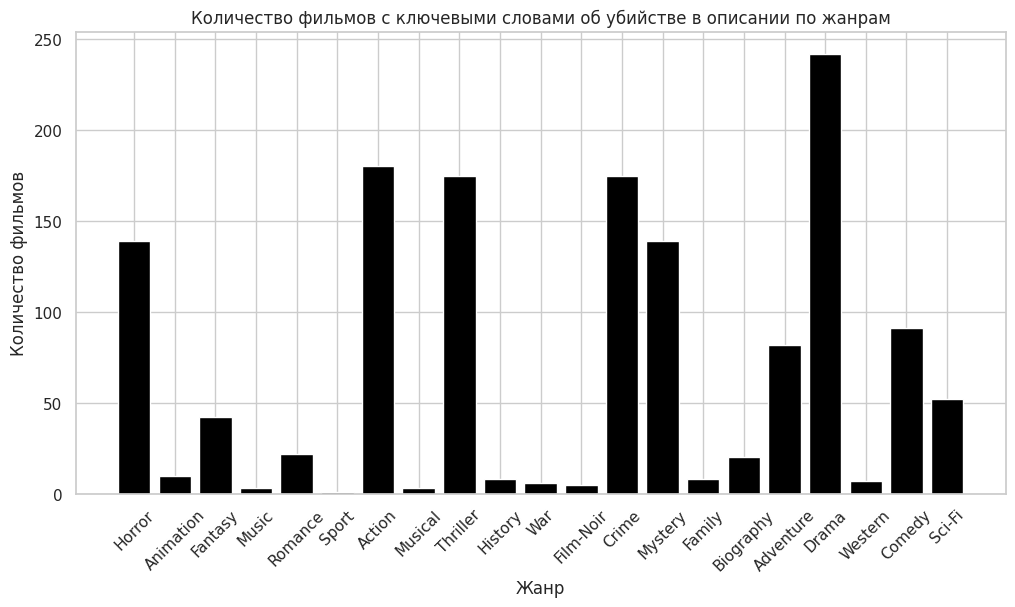

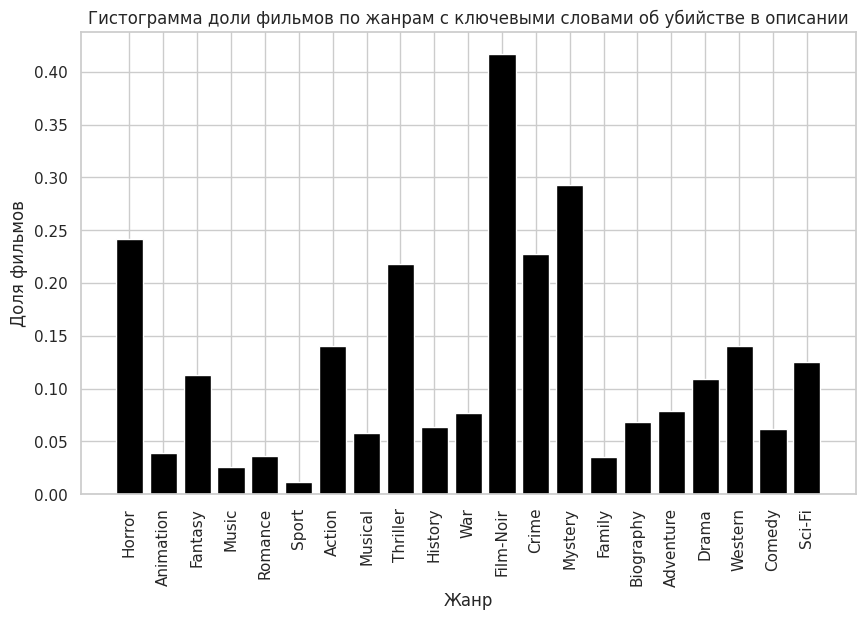

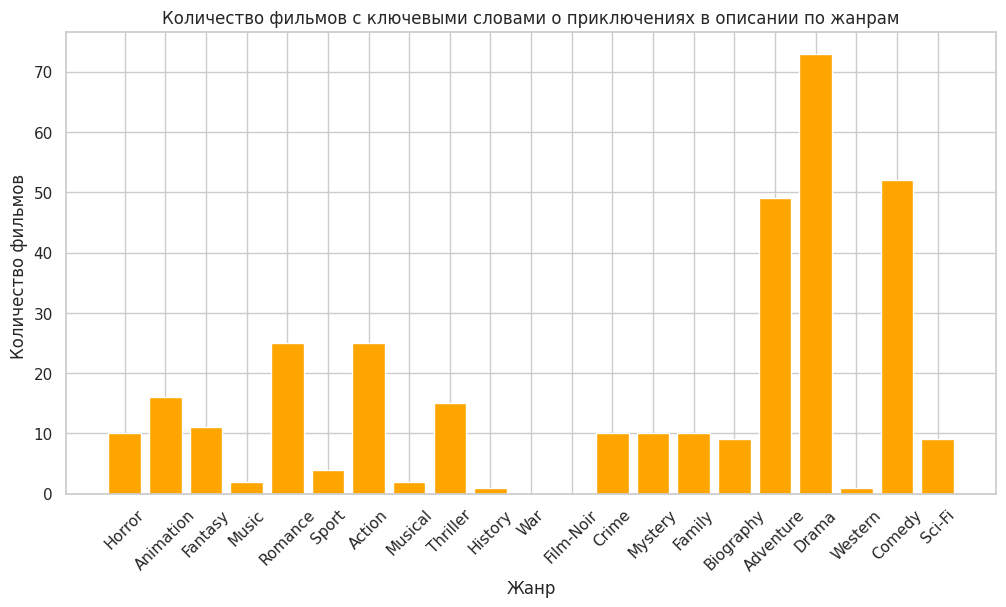

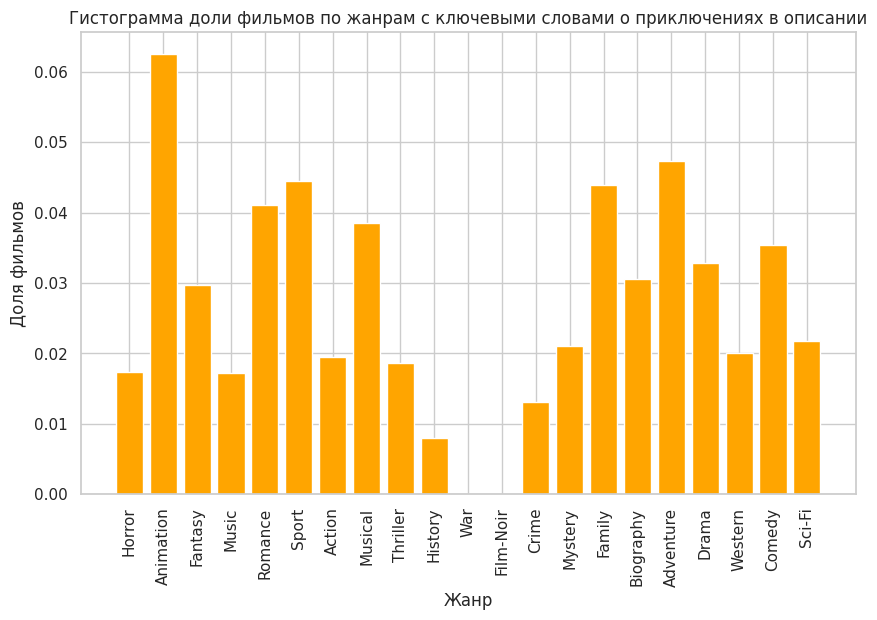

In [19]:
lemmatizer = WordNetLemmatizer()

# Создаем список уникальных жанров
genres = set()
for genre_list in df['genre']:
    genres.update(genre_list.split(', '))

for genre in genres:
    df[genre] = 0

for index, row in df.iterrows():
    genre_list = row['genre'].split(', ')
    for genre in genre_list:
        df.at[index, genre] = 1

with open('death_words.txt', 'r') as file:
    death_list = file.read().splitlines()

with open('journey_words.txt', 'r') as file:
    adventure_list = file.read().splitlines()

# Проверяем наличие в описании ключевых слов
def check_death_keywords(text):
    keywords = death_list
    tokens = word_tokenize(text.lower())
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    for keyword in keywords:
        if keyword in lemmatized_tokens:
            return 1, keyword  # Если найдено хотя бы одно ключевое слово
    return 0, None  # Если ключевые слова не найдены

def check_journey_keywords(text):
    keywords = adventure_list
    tokens = word_tokenize(text.lower())
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    for keyword in keywords:
        if keyword in lemmatized_tokens:
            return 1, keyword
    return 0, None


df_death = df
df_journey = df

df_death['contains_keywords'], df_death['keyword'] = zip(*df['description'].apply(check_death_keywords))

# Фильтруем строки с ключевыми словами
filtered_death_df = df_death[df_death['contains_keywords'] == 1]
genre_counts = filtered_death_df[genres].sum()

#  диаграмма
plt.figure(figsize=(12, 6))
plt.bar(genre_counts.index, genre_counts.values,  color = 'black')
plt.title('Количество фильмов с ключевыми словами об убийстве в описании по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Количество фильмов')
plt.xticks(rotation=45)
plt.show()

# Вычисляем общее количество фильмов каждого жанра в исходной таблице и долю фильмов с keywords
genre_counts_total = df_death[genres].sum()
filtered_death_df = df_death[df_death['contains_keywords'] == 1]
genre_ratios = filtered_death_df[genres].sum() / genre_counts_total

#  гистограмма
plt.figure(figsize=(10, 6))
plt.bar(genre_ratios.index, genre_ratios, color = 'black')
plt.xlabel('Жанр')
plt.ylabel('Доля фильмов')
plt.title('Гистограмма доли фильмов по жанрам с ключевыми словами об убийстве в описании')
plt.xticks(rotation=90)
plt.show()

df_journey['contains_keywords'], df_journey['keyword'] = zip(*df['description'].apply(check_journey_keywords))
filtered_journey_df = df_journey[df_journey['contains_keywords'] == 1]
genre_counts = filtered_journey_df[genres].sum()

#  диаграмма
plt.figure(figsize=(12, 6))
plt.bar(genre_counts.index, genre_counts.values,  color = 'orange')
plt.title('Количество фильмов с ключевыми словами о приключениях в описании по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Количество фильмов ')
plt.xticks(rotation=45)
plt.show()

genre_counts_total = df_journey[genres].sum()
genre_ratios = filtered_journey_df[genres].sum() / genre_counts_total

# гистограмма
plt.figure(figsize=(10, 6))
plt.bar(genre_ratios.index, genre_ratios, color = 'orange')
plt.xlabel('Жанр')
plt.ylabel('Доля фильмов')
plt.title('Гистограмма доли фильмов по жанрам с ключевыми словами о приключениях в описании')
plt.xticks(rotation=90)
plt.show()

**Выводы:**
Про убийства:
1. Подтвердили предположение о том, что чаще всего в описании убийства есть у хорроров, драм, нуар-фильмов, криминальных картин. Что интересно: очень много убийств в приключенческих фильмах — почти 250 штук (было неочевидно)

2. Про долю фильмов, в описании которых есть убийства: самый большой показатель оказался у нуар-картин (больше 40%), хотя обычно это не тот жанр, который ты вообще выделяешь отдельно. У хорроров, mystery и криминальных доля сильно меньше.

Про приключения:
1. Здесь сильно более логично — максимум у приключений и драм, еще есть упоминания у экшн, романтик и анимаций.
2. При этом несмотря на то, что в целом упоминаний приключений у анимаций не так много, среди всех анимаций приключения есть в 6% фильмов. У приключений этот показатель меньше 5%. Еще по доле упоминаний вырываютя семейные фильмы и спортивные, что тоже интересно.

## 2. Проверим то же самое для тематик войны и мира

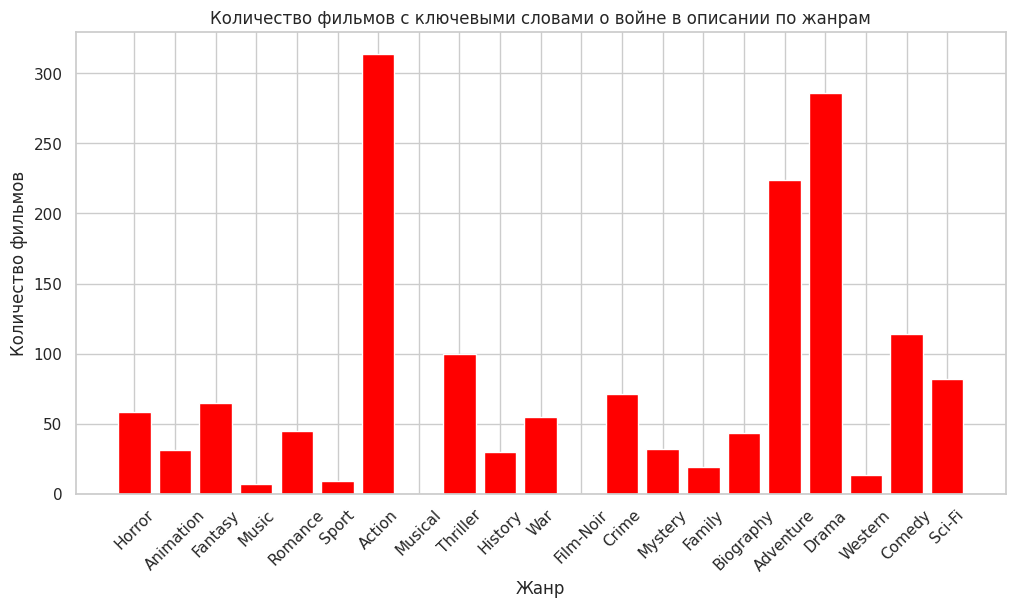

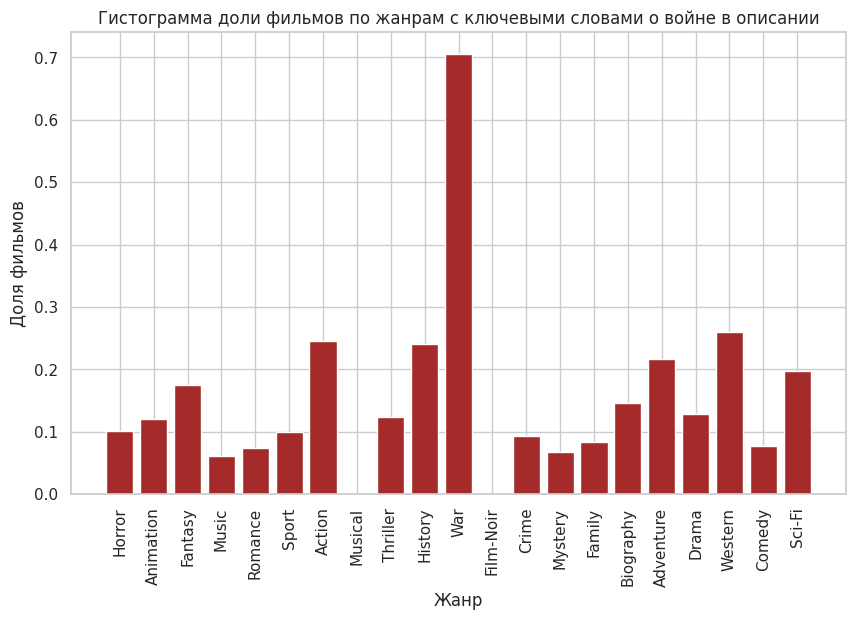

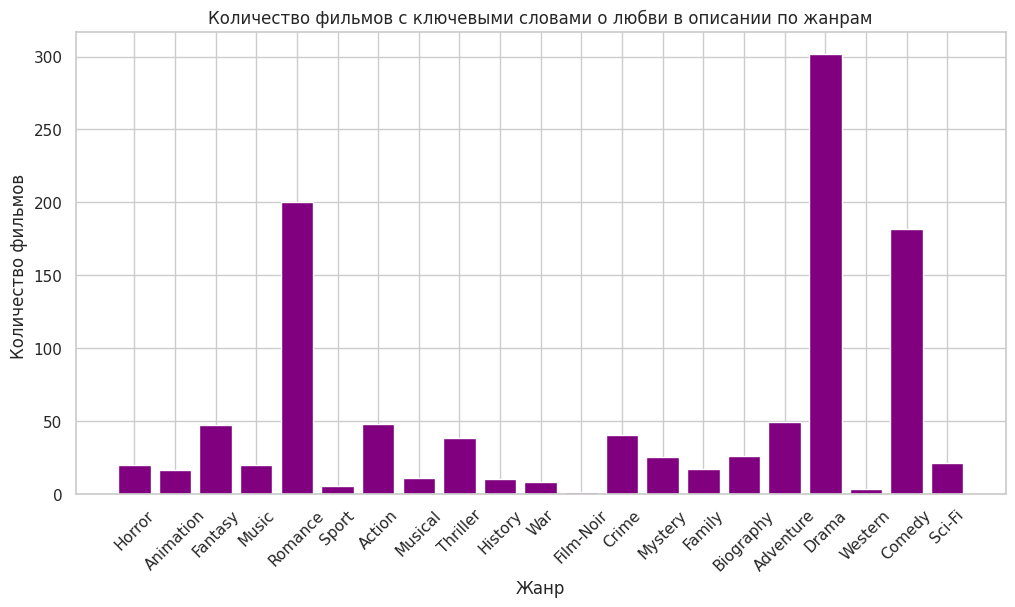

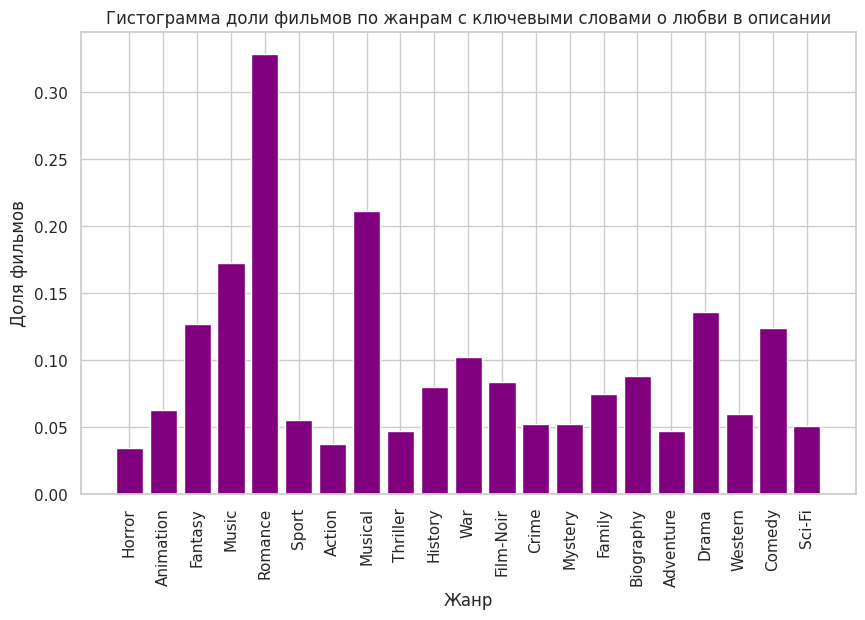

In [20]:
genres = set()
for genre_list in df['genre']:
    genres.update(genre_list.split(', '))
for genre in genres:
    df[genre] = 0

for index, row in df.iterrows():
    genre_list = row['genre'].split(', ')
    for genre in genre_list:
        df.at[index, genre] = 1

with open('love_words.txt', 'r') as file:
    love_word_list = file.read().splitlines()

with open('war_words.txt', 'r') as file:
    war_word_list = file.read().splitlines()

def check_war_keywords(text):
    keywords = war_word_list
    tokens = word_tokenize(text.lower())
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    for keyword in keywords:
        if keyword in lemmatized_tokens:
            return 1, keyword
    return 0, None

def check_love_keywords(text):
    keywords = love_word_list
    tokens = word_tokenize(text.lower())
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    for keyword in keywords:
        if keyword in lemmatized_tokens:
            return 1, keyword
    return 0, None


df_war = df
df_love = df
df_war['contains_keywords'], df_war['keyword'] = zip(*df['description'].apply(check_war_keywords))
filtered_war_df = df_war[df_war['contains_keywords'] == 1]
genre_counts = filtered_war_df[genres].sum()

# диаграмма
plt.figure(figsize=(12, 6))
plt.bar(genre_counts.index, genre_counts.values, color = 'red')
plt.title('Количество фильмов с ключевыми словами о войне в описании по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Количество фильмов')
plt.xticks(rotation=45)
plt.show()

genre_counts_total = df_war[genres].sum()
genre_ratios = filtered_war_df[genres].sum() / genre_counts_total

# гистограмма
plt.figure(figsize=(10, 6))
plt.bar(genre_ratios.index, genre_ratios, color = 'brown')
plt.xlabel('Жанр')
plt.ylabel('Доля фильмов')
plt.title('Гистограмма доли фильмов по жанрам с ключевыми словами о войне в описании')
plt.xticks(rotation=90)
plt.show()

df_love['contains_keywords'], df_love['keyword'] = zip(*df['description'].apply(check_love_keywords))
filtered_love_df = df_love[df_love['contains_keywords'] == 1]
genre_counts = filtered_love_df[genres].sum()

# диаграмма
plt.figure(figsize=(12, 6))
plt.bar(genre_counts.index, genre_counts.values, color = 'purple')
plt.title('Количество фильмов с ключевыми словами о любви в описании по жанрам')
plt.xlabel('Жанр')
plt.ylabel('Количество фильмов ')
plt.xticks(rotation=45)
plt.show()

genre_counts_total = df_love[genres].sum()
genre_ratios = filtered_love_df[genres].sum() / genre_counts_total

# гистограмма
plt.figure(figsize=(10, 6))
plt.bar(genre_ratios.index, genre_ratios, color = 'purple')
plt.xlabel('Жанр')
plt.ylabel('Доля фильмов')
plt.title('Гистограмма доли фильмов по жанрам с ключевыми словами о любви в описании')
plt.xticks(rotation=90)
plt.show()

### Выводы:

 **Про войну:**
 1. Интересно, что больше всего про войну упоминаний в экшн (300+), приключенческих(+-230) и драматических (+-270) фильмах. Предварительно думали, что такие показатели будут для боевиков и документалок, но конкретно таких жанров нет.
 2. В жанре war супер мало упоминаний тематических слов, но это именно из-за самого количества фильмов, тк доля упоминаний в итоге — 70%
 3. Доли в драме и приключениях — около 20%. В этой же части появляются исторические фильмы, фэнтези и sci-fic.

 **Про любовь:**
1. Лидеры (очевидно) — драмы и романтика, топ-3 — комедии, что забавно, но в целом предсказуемо
2. Когда смотрим на доли: значимая доля упоминаний есть в музыкальных фильмах (17%), мюзиклах (больше 20%) и фэнтези (+- 12%).

## Резюме по этой части:

посмотрели на популярные жанры и начали играться с лингвистическими признаками. Выявили, что часто в тематических блоках повляются неожиданные жанры. Исходя из этого на следующем этапе посмотрим, а какие вообще слова наиболее часто используются в описании разных жанров.